In [2]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [39]:
ref=pd.read_pickle("../01_preparation/clear-fusion/clear-fusion_tama_augustus.pkl")

In [13]:
ref = ref.loc[ref["cat_assign"]=="fusion"]

## Fusion genes - general

In [14]:
def subsample(df, len_nlr, refname):
        ### Random subsampling form the genome
        # Preparation
        n=len_nlr
        subs_all, cats_all=[],[]
        subs_dict, cats_dict={},{}
        subs_final, cats_final={},{}
        np.random.seed(42)
        seeds = np.random.choice(range(999999), size=10000, replace=False)

        # get snapshot of one iteration
        for i in range(len(seeds)):
            sub_df = df.sample(n, random_state=seeds[i], axis=0)
            subs_all.append(sub_df["subcategory"])
            cats_all.append(sub_df["structural_category"])

        # count occurences of all snapshots
        for subset in subs_all:
            for gene in subset:
                if gene in subs_dict.keys():
                    subs_dict[gene] +=1
                else:
                    subs_dict[gene] = 1
                    
        for subset in cats_all:
            for gene in subset:
                if gene in cats_dict.keys():
                    cats_dict[gene] +=1
                else:
                    cats_dict[gene] = 1

        # average the accumulated snaphot counts by the number of snapshots and get the probability by dividing all by all genes
        for key in subs_dict.keys():
            subs_final[key] = subs_dict[key]/len(seeds)
            
        for key in cats_dict.keys():
            cats_final[key] = cats_dict[key]/len(seeds)
                
        subs_iters = pd.DataFrame.from_dict(subs_final, orient='index',columns=[f"{refname}_iters_subs"])
        subs_iters[f"{refname}_iters_subs_proportion"] = subs_iters[f"{refname}_iters_subs"]/n
        
        cats_iters = pd.DataFrame.from_dict(cats_final, orient='index',columns=[f"{refname}_iters_cats"])
        cats_iters[f"{refname}_iters_cats_proportion"] = cats_iters[f"{refname}_iters_cats"]/n
        
        return subs_iters, cats_iters

In [15]:
run_subs=pd.DataFrame()
run_cats=pd.DataFrame()

for acc in tqdm(ref["accession"].unique().tolist()):
    at = ref.loc[ref["accession"] == acc].copy()
    nlr = at.loc[at["type"] == "nlr"].copy()
    busco = at.loc[at["type"] == "busco"].copy()
    house = at.loc[at["type"] == "housekeeping"].copy()
    n=min(len(nlr), len(busco), len(house), len(at))
    refsets=[nlr, busco, house, at]
    refnames=["nlr", "busco", "house","all"]

    refset_subs_iters=pd.DataFrame()
    refset_cats_iters=pd.DataFrame()
    for refset, refname in zip(refsets, refnames):
        subs_iters, cats_iters = subsample(refset, n, refname)
        refset_subs_iters=pd.concat([refset_subs_iters,subs_iters], axis="columns")
        refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

    ### combine all
    # Take care of subs
    a=pd.DataFrame(nlr["subcategory"].value_counts())
    a.columns=["nlr_subs"]
    a["nlr_subs_proportion"]=a["nlr_subs"]/len(nlr)

    b=pd.DataFrame(busco["subcategory"].value_counts())
    b.columns=["busco_subs"]
    b["busco_subs_proportion"]=b["busco_subs"]/len(busco)

    c=pd.DataFrame(house["subcategory"].value_counts())
    c.columns=["housekeeping_subs"]
    c["housekeeping_subs_proportion"]=c["housekeeping_subs"]/len(house)

    e=pd.DataFrame(at["subcategory"].value_counts())
    e.columns=["all_subs"]
    e["all_subs_proportion"]=e["all_subs"]/len(at)

    acc_subs=pd.concat([a,refset_subs_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_subs["accession"] = acc
    run_subs=pd.concat([run_subs, acc_subs])

    ### combine all
    # Take care of cats
    a=pd.DataFrame(nlr["structural_category"].value_counts())
    a.columns=["nlr_cats"]
    a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

    b=pd.DataFrame(busco["structural_category"].value_counts())
    b.columns=["busco_cats"]
    b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

    c=pd.DataFrame(house["structural_category"].value_counts())
    c.columns=["housekeeping_cats"]
    c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

    e=pd.DataFrame(at["structural_category"].value_counts())
    e.columns=["all_cats"]
    e["all_cats_proportion"]=e["all_cats"]/len(at)

    acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_cats["accession"] = acc
    run_cats=pd.concat([run_cats, acc_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [04:39<00:00, 15.54s/it]


In [16]:
run_subs.to_pickle("fusions_all/run_subs.pkl")
run_cats.to_pickle("fusions_all/run_cats.pkl")

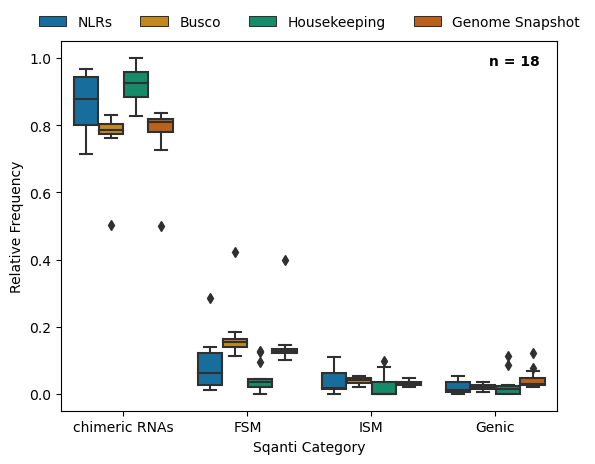

In [4]:
run_cats=pd.read_pickle("fusions_all/run_cats.pkl")
fus_cats=run_cats[["index","accession","nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"]]

sns.set_palette(sns.color_palette("colorblind"))

plot1=fus_cats.melt(id_vars=["index","accession"], value_vars=["nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"])

plot1["variable_plot"] = plot1["variable"].map({'nlr_cats_proportion': 'NLRs', 'busco_cats_proportion': 'Busco', 'housekeeping_cats_proportion': 'Housekeeping', 'all_iters_cats_proportion':'Genome Snapshot'})

plt1=sns.boxplot(data=plot1, x="index",y="value", hue="variable_plot", order=["fusion","full-splice_match","incomplete-splice_match","genic"])
plt1.set_xticklabels(["chimeric RNAs","FSM","ISM","Genic"])
plt1.set_ylabel("Relative Frequency")
plt1.set_xlabel("Sqanti Category")

plt1.text(2.95, 0.98, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')

sns.move_legend(
    plt1, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

fig = plt1.get_figure()
fig.savefig("fusion_genes_categories.png", bbox_inches='tight', dpi=200)

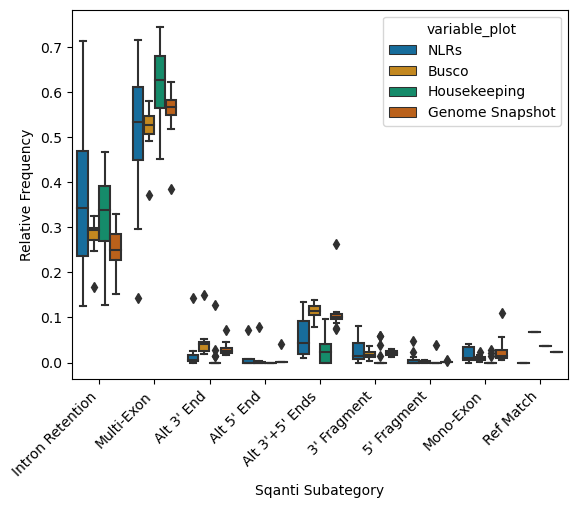

In [91]:
fus_subs=pd.read_pickle("fusions_all/run_subs.pkl")
fus_subs=run_subs[["index","accession","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

sns.set_palette(sns.color_palette("colorblind"))

plot2=fus_subs.melt(id_vars=["index","accession"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

plot2["variable_plot"] = plot2["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})

plt2=sns.boxplot(data=plot2, x="index",y="value", hue="variable_plot", order=['intron_retention','multi-exon','alternative_3end','alternative_5end','alternative_3end5end','3prime_fragment','5prime_fragment','mono-exon','reference_match'])
plt2.set_xticklabels(["Intron Retention", "Multi-Exon","Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment","Mono-Exon","Ref Match"], rotation=45,horizontalalignment='right')
plt2.set_ylabel("Relative Frequency")
plt2.set_xlabel("Sqanti Subategory")

fig = plt2.get_figure()
fig.savefig("fusion_genes_subcat.png", bbox_inches='tight')

## Fusion genes vs fusion reads

In [29]:
fr=ref.loc[~(ref["structural_category"]=="fusion")].copy()
fr["plot"] = "single"
fr["coding"]="no"
fr["coding"].loc[~(fr["Sqanti_ORF_seq"].isna())]="yes"
fr.loc[fr["coding"]=="yes"]

/tmp/ipykernel_110392/1335991402.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr["coding"].loc[~(fr["Sqanti_ORF_seq"].isna())]="yes"


,gene,isoform,accession,associated_gene,associated_transcript,exons,length,isoform_read_support,gene_read_support,structural_category,...,cat_assign,association,cat_read_support,gene_association_read_support,type,isoforms_per_gene,ORFs_per_gene,isoforms_per_ORFs,plot,coding
2366,G1795,G1795.1,at6923,g2609_g2610,g2610.t1,5,4571,1,3,full-splice_match,...,fusion,2,1,1,nlr,3,3,1.0,single,yes
2427,G2999,G2999.63,at6923,g5576_g5577,novel,1,3194,1,84,genic,...,fusion,2,80,80,nlr,73,23,1.0,single,yes
2437,G2999,G2999.72,at6923,g5576_g5577,novel,1,2549,1,84,genic,...,fusion,2,80,80,nlr,73,23,3.0,single,yes
2441,G3022,G3022.1,at6923,g5615_g5616,novel,5,2999,1,1,genic,...,fusion,2,1,1,nlr,1,1,1.0,single,yes
2444,G3255,G3255.5,at6923,g6034_g6035,g6035.t1,4,3959,1,17,full-splice_match,...,fusion,2,3,3,nlr,17,6,12.0,single,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419856,G16298,G16298.61,col0,ATCG01240_ATCG01230,ATCG01230.1,2,1082,2,223,full-splice_match,...,fusion,2,132,131,other,82,12,71.0,single,yes
3419857,G16298,G16298.65,col0,ATCG01240_ATCG01230,ATCG01230.1,2,995,2,223,full-splice_match,...,fusion,2,132,131,other,82,12,71.0,single,yes
3419858,G16298,G16298.7,col0,ATCG01240_ATCG01230,ATCG01230.1,2,1833,12,223,full-splice_match,...,fusion,2,132,131,other,82,12,71.0,single,yes
3419859,G16298,G16298.70,col0,ATCG01240_ATCG01230,ATCG01230.1,2,832,1,223,full-splice_match,...,fusion,2,132,131,other,82,12,71.0,single,yes


In [30]:
fr_run_subs=pd.DataFrame()
fr_run_cats=pd.DataFrame()

for acc in tqdm(fr["accession"].unique().tolist()):
    at = fr.loc[fr["accession"] == acc].copy()
    nlr = at.loc[at["type"] == "nlr"].copy()
    busco = at.loc[at["type"] == "busco"].copy()
    house = at.loc[at["type"] == "housekeeping"].copy()
    n=min(len(nlr), len(busco), len(house), len(at))
    refsets=[nlr, busco, house, at]
    refnames=["nlr", "busco", "house","all"]

    refset_subs_iters=pd.DataFrame()
    refset_cats_iters=pd.DataFrame()
    for refset, refname in zip(refsets, refnames):
        subs_iters, cats_iters = subsample(refset, n, refname)
        refset_subs_iters=pd.concat([refset_subs_iters,subs_iters], axis="columns")
        refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

    ### combine all
    # Take care of subs
    a=pd.DataFrame(nlr["subcategory"].value_counts())
    a.columns=["nlr_subs"]
    a["nlr_subs_proportion"]=a["nlr_subs"]/len(nlr)

    b=pd.DataFrame(busco["subcategory"].value_counts())
    b.columns=["busco_subs"]
    b["busco_subs_proportion"]=b["busco_subs"]/len(busco)

    c=pd.DataFrame(house["subcategory"].value_counts())
    c.columns=["housekeeping_subs"]
    c["housekeeping_subs_proportion"]=c["housekeeping_subs"]/len(house)

    e=pd.DataFrame(at["subcategory"].value_counts())
    e.columns=["all_subs"]
    e["all_subs_proportion"]=e["all_subs"]/len(at)

    acc_subs=pd.concat([a,refset_subs_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_subs["accession"] = acc
    fr_run_subs=pd.concat([fr_run_subs, acc_subs])

    ### combine all
    # Take care of cats
    a=pd.DataFrame(nlr["structural_category"].value_counts())
    a.columns=["nlr_cats"]
    a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

    b=pd.DataFrame(busco["structural_category"].value_counts())
    b.columns=["busco_cats"]
    b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

    c=pd.DataFrame(house["structural_category"].value_counts())
    c.columns=["housekeeping_cats"]
    c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

    e=pd.DataFrame(at["structural_category"].value_counts())
    e.columns=["all_cats"]
    e["all_cats_proportion"]=e["all_cats"]/len(at)

    acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_cats["accession"] = acc
    fr_run_cats=pd.concat([fr_run_cats, acc_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [04:40<00:00, 15.58s/it]


In [32]:
fr_run_subs.to_pickle("fusions_all/fr_run_subs.pkl")
fr_run_cats.to_pickle("fusions_all/fr_run_cats.pkl")

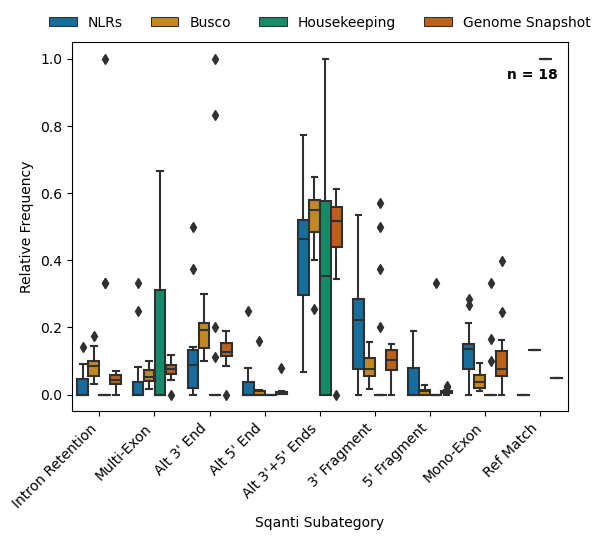

In [92]:
fr_fus_subs=pd.read_pickle("fusions_all/fr_run_subs.pkl")
fr_fus_subs=fr_run_subs[["index","accession","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

sns.set_palette(sns.color_palette("colorblind"))

plot3=fr_fus_subs.melt(id_vars=["index","accession"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])
plot3["variable_plot"] = plot3["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})


plt3=sns.boxplot(data=plot3, x="index",y="value", hue="variable_plot", order=['intron_retention','multi-exon','alternative_3end','alternative_5end','alternative_3end5end','3prime_fragment','5prime_fragment','mono-exon','reference_match'])
plt3.set_xticklabels(["Intron Retention", "Multi-Exon","Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment","Mono-Exon","Ref Match"], rotation=45,horizontalalignment='right')
plt3.set_ylabel("Relative Frequency")
plt3.set_xlabel("Sqanti Subategory")

plt3.text(7.4, 0.94, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')


sns.move_legend(
    plt3, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
fig = plt3.get_figure()
fig.savefig("fusion_reads_subcats.png", bbox_inches='tight', dpi=200)

In [34]:
fg=ref.loc[ref["structural_category"]=="fusion"].copy()
fg["plot"] = "fusion"
fg["coding"]="no"
fg["coding"].loc[~(fg["Sqanti_ORF_seq"].isna())]="yes"
fg.loc[fg["coding"]=="no"]

/tmp/ipykernel_110392/3413143482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fg["coding"].loc[~(fg["Sqanti_ORF_seq"].isna())]="yes"


,gene,isoform,accession,associated_gene,associated_transcript,exons,length,isoform_read_support,gene_read_support,structural_category,...,cat_assign,association,cat_read_support,gene_association_read_support,type,isoforms_per_gene,ORFs_per_gene,isoforms_per_ORFs,plot,coding
9027,G2954,G2954.44,at9104,g5472_g5473,novel,3,1178,1,50,fusion,...,fusion,2,40,40,nlr,45,22,NaN,fusion,no
9028,G2954,G2954.45,at9104,g5472_g5473,novel,3,1717,1,50,fusion,...,fusion,2,40,40,nlr,45,22,NaN,fusion,no
10865,G15165,G15165.3,at9336,g29883_g29882,novel,2,2033,1,14,fusion,...,fusion,2,1,1,nlr,9,5,NaN,fusion,no
25867,G15494,G15494.3,at9847,g29946_g29945,novel,2,720,1,3,fusion,...,fusion,2,2,2,nlr,3,3,NaN,fusion,no
30576,G14047,G14047.2,at9883,g29508_g29509,novel,6,1050,1,9,fusion,...,fusion,2,2,2,nlr,2,2,NaN,fusion,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419179,G9439,G9439.1,col0,AT3G55910_AT3G55890,novel,5,2094,1,2,fusion,...,fusion,2,2,2,other,2,2,NaN,fusion,no
3419452,G16258,G16258.349,col0,ATCG00180_ATCG00170_ATCG00190,novel,2,3820,1,1059,fusion,...,fusion,3,86,4,other,488,205,NaN,fusion,no
3419627,G16270,G16270.594,col0,ATCG00730_ATCG00720,novel,2,974,1,2696,fusion,...,fusion,2,728,411,other,471,108,NaN,fusion,no
3419636,G16274,G16274.17,col0,ATCG00660_ATCG00670,novel,2,2530,1,1485,fusion,...,fusion,2,1,1,other,53,53,NaN,fusion,no


In [35]:
fg_run_subs=pd.DataFrame()
fg_run_cats=pd.DataFrame()

for acc in tqdm(fg["accession"].unique().tolist()):
    at = fg.loc[fg["accession"] == acc].copy()
    nlr = at.loc[at["type"] == "nlr"].copy()
    busco = at.loc[at["type"] == "busco"].copy()
    house = at.loc[at["type"] == "housekeeping"].copy()
    n=min(len(nlr), len(busco), len(house), len(at))
    refsets=[nlr, busco, house, at]
    refnames=["nlr", "busco", "house","all"]

    refset_subs_iters=pd.DataFrame()
    refset_cats_iters=pd.DataFrame()
    for refset, refname in zip(refsets, refnames):
        subs_iters, cats_iters = subsample(refset, n, refname)
        refset_subs_iters=pd.concat([refset_subs_iters,subs_iters], axis="columns")
        refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

    ### combine all
    # Take care of subs
    a=pd.DataFrame(nlr["subcategory"].value_counts())
    a.columns=["nlr_subs"]
    a["nlr_subs_proportion"]=a["nlr_subs"]/len(nlr)

    b=pd.DataFrame(busco["subcategory"].value_counts())
    b.columns=["busco_subs"]
    b["busco_subs_proportion"]=b["busco_subs"]/len(busco)

    c=pd.DataFrame(house["subcategory"].value_counts())
    c.columns=["housekeeping_subs"]
    c["housekeeping_subs_proportion"]=c["housekeeping_subs"]/len(house)

    e=pd.DataFrame(at["subcategory"].value_counts())
    e.columns=["all_subs"]
    e["all_subs_proportion"]=e["all_subs"]/len(at)

    acc_subs=pd.concat([a,refset_subs_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_subs["accession"] = acc
    fg_run_subs=pd.concat([fg_run_subs, acc_subs])

    ### combine all
    # Take care of cats
    a=pd.DataFrame(nlr["structural_category"].value_counts())
    a.columns=["nlr_cats"]
    a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

    b=pd.DataFrame(busco["structural_category"].value_counts())
    b.columns=["busco_cats"]
    b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

    c=pd.DataFrame(house["structural_category"].value_counts())
    c.columns=["housekeeping_cats"]
    c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

    e=pd.DataFrame(at["structural_category"].value_counts())
    e.columns=["all_cats"]
    e["all_cats_proportion"]=e["all_cats"]/len(at)

    acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_cats["accession"] = acc
    fg_run_cats=pd.concat([fg_run_cats, acc_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [04:44<00:00, 15.78s/it]


In [36]:
fg_run_subs.to_pickle("fusions_all/fg_run_subs.pkl")
fg_run_cats.to_pickle("fusions_all/fg_run_cats.pkl")

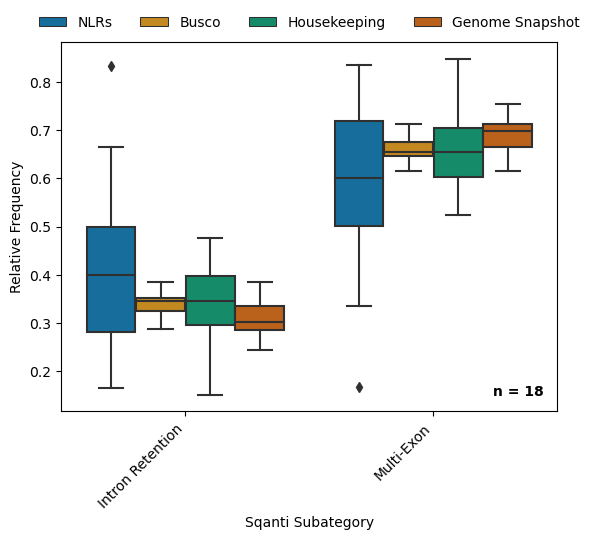

In [93]:
fg_fus_subs=pd.read_pickle("fusions_all/fg_run_subs.pkl")
fg_fus_subs=fg_run_subs[["index","accession","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

sns.set_palette(sns.color_palette("colorblind"))

plot4=fg_fus_subs.melt(id_vars=["index","accession"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])
plot4["variable_plot"] = plot4["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})


plt4=sns.boxplot(data=plot4, x="index",y="value", hue="variable_plot")


plot4["variable_plot"] = plot4["variable"].map({'nlr_cats_proportion': 'NLRs', 'busco_cats_proportion': 'Busco', 'housekeeping_cats_proportion': 'Housekeeping', 'all_iters_cats_proportion':'Genome Snapshot'})

plt4.set_xticklabels(["Intron Retention","Multi-Exon"], rotation=45,horizontalalignment='right')
plt4.set_ylabel("Relative Frequency")
plt4.set_xlabel("Sqanti Subategory")


plt4.text(1.24, 0.15, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')


sns.move_legend(
    plt4, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

fig = plt4.get_figure()
fig.savefig("fusion_genes_subcats.png", bbox_inches='tight', dpi=200)

In [118]:
test=pd.concat([fr,fg])

In [146]:
c=pd.DataFrame()
for acc in test.groupby("accession"):
    x=acc[1]["plot"].value_counts(normalize=True).rename_axis('cat').reset_index(name='counts')
    x["accession"]=acc[0]
    c=pd.concat([c,x])

<AxesSubplot:xlabel='cat', ylabel='counts'>

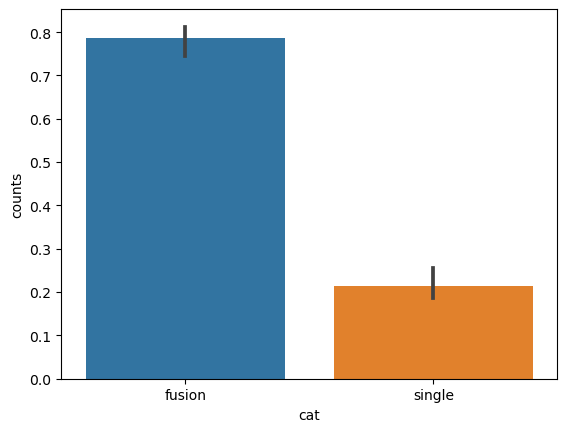

In [155]:
sns.barplot(data=c, x="cat", y="counts")

In [57]:
#check of a transcript is marked as non coding, if it has an ORF
accessions = ref["accession"].unique().tolist()
for acc in accessions:
    sqanti = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/output/v2/collapse_tama/{}_augustus_sqanti/{}-tama-vs-augustus_classification.txt".format(acc,acc), sep="\t")
    coding=sqanti.loc[sqanti["coding"]=="coding"]
    if coding["ORF_seq"].isnull().values.any():
        print(acc)
        print("Coding ORF: NA")
    noncoding=sqanti.loc[sqanti["coding"]=="non_coding"]
    print(noncoding.loc[~(noncoding["ORF_seq"].isna())])

Empty DataFrame
Columns: [isoform, chrom, strand, length, exons, structural_category, associated_gene, associated_transcript, ref_length, ref_exons, diff_to_TSS, diff_to_TTS, diff_to_gene_TSS, diff_to_gene_TTS, subcategory, RTS_stage, all_canonical, min_sample_cov, min_cov, min_cov_pos, sd_cov, FL, n_indels, n_indels_junc, bite, iso_exp, gene_exp, ratio_exp, FSM_class, coding, ORF_length, CDS_length, CDS_start, CDS_end, CDS_genomic_start, CDS_genomic_end, predicted_NMD, perc_A_downstream_TTS, seq_A_downstream_TTS, dist_to_CAGE_peak, within_CAGE_peak, dist_to_polyA_site, within_polyA_site, polyA_motif, polyA_dist, polyA_motif_found, ORF_seq, ratio_TSS]
Index: []

[0 rows x 48 columns]
Empty DataFrame
Columns: [isoform, chrom, strand, length, exons, structural_category, associated_gene, associated_transcript, ref_length, ref_exons, diff_to_TSS, diff_to_TTS, diff_to_gene_TSS, diff_to_gene_TTS, subcategory, RTS_stage, all_canonical, min_sample_cov, min_cov, min_cov_pos, sd_cov, FL, n_indel